In [1]:
from healthacc import multimodal_from_bbox, compute_travel_cost_adjlist

In [7]:
import pandas as pd

In [2]:
from geosnap import datasets, Community

Loading manifest: 100%|██████████| 3/3 [00:00<00:00, 1768.01entries/s]


In [4]:
dc_tracts = Community.from_census(msa_fips='47900', years=[2010]).gdf

In [5]:
balt_tracts = Community.from_census(msa_fips='12580', years=[2010]).gdf 

In [8]:
mega = pd.concat([dc_tracts, balt_tracts])

<AxesSubplot:>

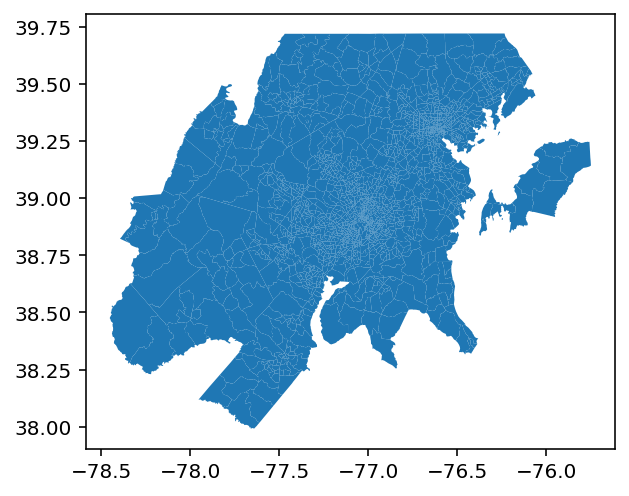

In [9]:
mega.plot()

In [10]:
mega_net = multimodal_from_bbox(bbox=tuple(mega.total_bounds), excluded_feeds=['newyorkshuttle', 'peterpanbuslines', 'amtrak'], headways=True)

Added 31 feeds to gtfs_feeds: {'mtamaryland': 'http://mta.maryland.gov/_googletransit/latest/google_transit.zip', 'wmata': 'https://lrg.wmata.com/GTFS_data/google_transit.zip', 'fairfaxconnector': 'https://www.fairfaxcounty.gov/connector/sites/connector/files/Assets/connector_gtfs.zip', 'virginiarailwayexpress': 'http://www.vre.org/gtfs/google_transit.zip', 'harfordtransitlink': 'https://github.com/mobilityequity/maryland-local-gtfs/raw/master/Harford_GTFS.zip', 'delmarvacommunitytransit': 'https://github.com/mobilityequity/maryland-local-gtfs/raw/master/Delmarva_GTFS.zip', 'washingtoncountycommuter': 'https://github.com/mobilityequity/maryland-local-gtfs/raw/master/WC_GTFS.zip', 'shoretransit': 'https://github.com/mobilityequity/maryland-local-gtfs/raw/master/Shore_GTFS.zip', 'ceciltransit': 'https://github.com/mobilityequity/maryland-local-gtfs/raw/master/Cecil_GTFS.zip', 'rabbittransit': 'http://www.rabbittransit.org/infopoint/gtfs/google_transit.zip', 'dartfirststate': 'http://dart

In [11]:
import geopandas as gpd

In [12]:
tests  = gpd.read_file("/Users/knaaptime/Dropbox/projects/healthacc/data/accessbility/Testing_Locations_7_15.shp")

In [14]:
from tqdm.auto import tqdm
import pandas as pd

In [15]:
tests['idx'] = tests.index

In [16]:
tests.idx = tests.idx.astype(str)

In [31]:
cost = compute_travel_cost_adjlist(mega, tests, mega_net, index_orig='geoid', index_dest='idx')

/Users/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [19]:
from access import weights as acweights

In [20]:
gravity = acweights.gravity(scale = 60, alpha = -1)
gaussian = acweights.gaussian(60)

In [21]:
cost.head()

,cost,destination,origin
0,4294967.295,0,11001009501
1,4294967.295,1,11001009501
2,1385.638,2,11001009501
3,1385.638,3,11001009501
4,1809.042,4,11001009501


In [22]:
from access import access as Access

In [23]:
tests['count'] =1

In [32]:
ac_test=Access(demand_df = mega,
            demand_index = 'geoid',
            demand_value = 'n_total_pop',
            supply_df    = tests,
            supply_index = 'idx',
            cost_df=cost.replace(0.0,1.0),  # gravity chokes if travel time is 0
            cost_origin='origin',
            cost_dest='destination',
            cost_name='cost',
            supply_value='count',
            neighbor_cost_df     = cost.replace(0.0,1.0),
            neighbor_cost_origin = 'origin',
            neighbor_cost_dest   = 'destination',
            neighbor_cost_name   = 'cost'
      )
try: 
    ac_test.raam(name = "raam", tau = 60);
    ac_test.access_df["raam_count"] = 1 / ac_test.access_df["raam_count"] 
except:
    print('raam failed')
ac_test.two_stage_fca(name ="2sfca", max_cost = 60,)
ac_test.enhanced_two_stage_fca(name = "g2sfca", weight_fn = gaussian)
ac_test.three_stage_fca(name = "3sfca")
ac_test.weighted_catchment(name = "catch_gravity", weight_fn = gravity)
ac_test.weighted_catchment(name = "catch_gaussian", weight_fn = gaussian)
ac_test.fca_ratio(name = "fca60",      max_cost = 30)
ac_test.fca_ratio(name = "fca120",      max_cost = 60) 

/Users/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/access/fca.py:137: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel = 1)
/Users/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/access/fca.py:137: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel = 1)


,fca120_count
geoid,
11001000100,NaN
11001000201,NaN
11001000202,NaN
11001000300,NaN
11001000400,NaN
...,...
54037972601,NaN
54037972602,NaN
54037972701,NaN


In [25]:
ac_test.access_df

,n_total_pop,raam_count,2sfca_count,g2sfca_count,3sfca_count,catch_gravity_count,catch_gaussian_count,fca60_count,fca120_count
geoid,,,,,,,,,
11001000100,5040.0,0.045004,0.000050,0.000063,0.000052,539.134672,58.103513,NaN,NaN
11001000201,4074.0,0.036214,0.000027,0.000049,0.000065,510.189553,47.099309,NaN,NaN
11001000202,4976.0,0.066613,0.000051,0.000060,0.000052,529.795817,56.140785,NaN,NaN
11001000300,5399.0,0.033536,0.000032,0.000053,0.000070,521.161221,50.926923,NaN,NaN
11001000400,1514.0,0.069785,0.000033,0.000049,0.000026,506.568441,48.444341,NaN,NaN
...,...,...,...,...,...,...,...,...,...
54037972601,1942.0,0.072570,NaN,0.000054,0.000000,343.169914,0.953607,NaN,NaN
54037972602,3999.0,0.077363,NaN,0.000021,0.000000,342.675116,0.371208,NaN,NaN
54037972701,2797.0,0.068042,NaN,0.000006,0.000000,339.708091,0.105590,NaN,NaN


In [26]:
cols = ac_test.access_df.columns.tolist()

In [27]:
cols.remove('n_total_pop')

<AxesSubplot:>

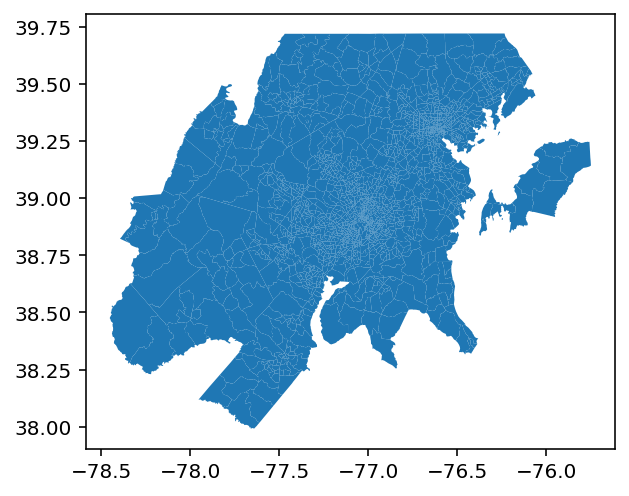

In [30]:
mega.plot()

/Users/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


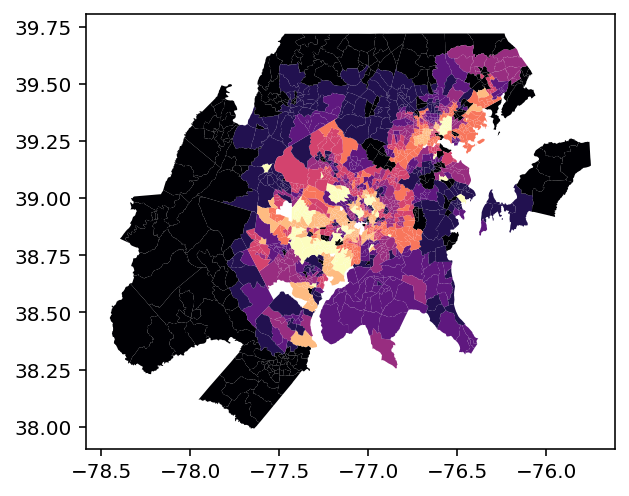

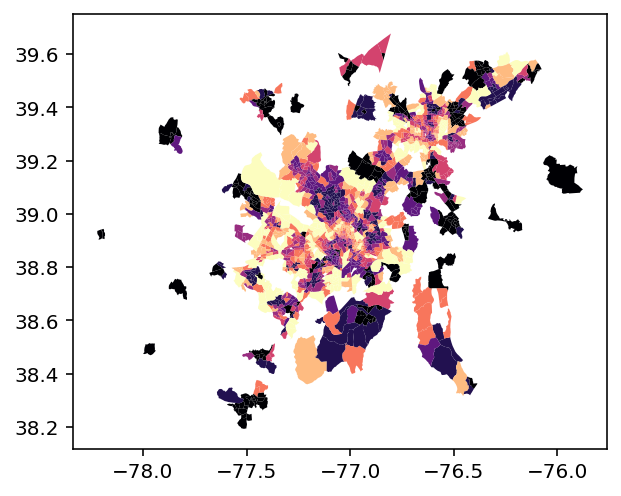

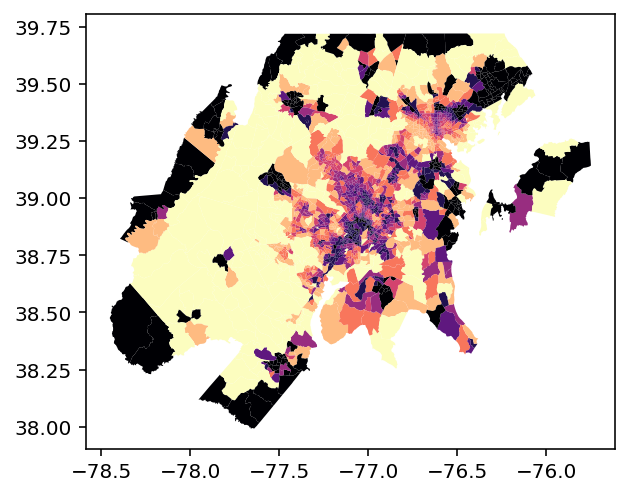

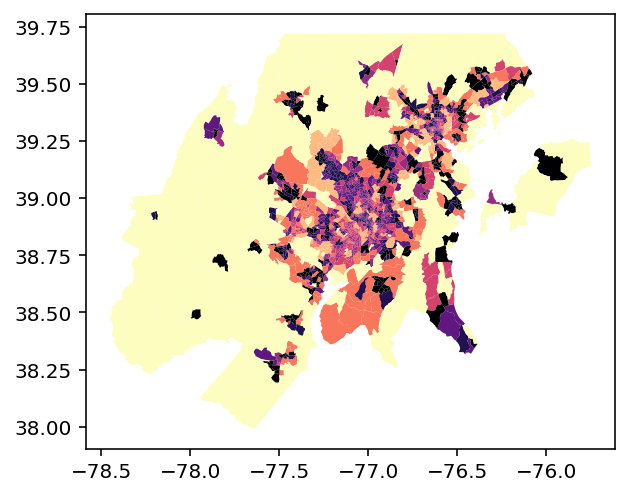

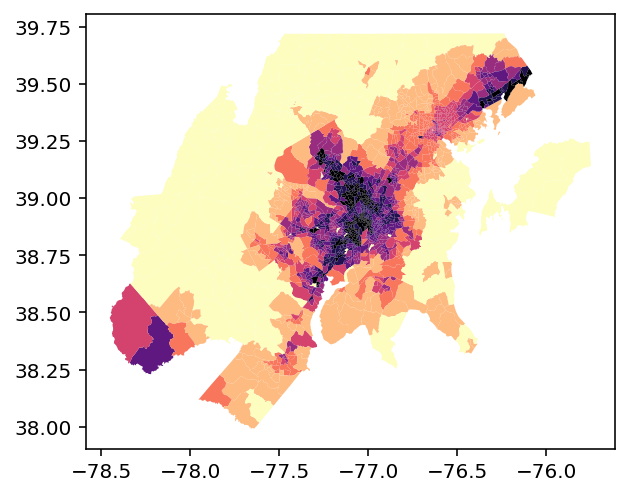

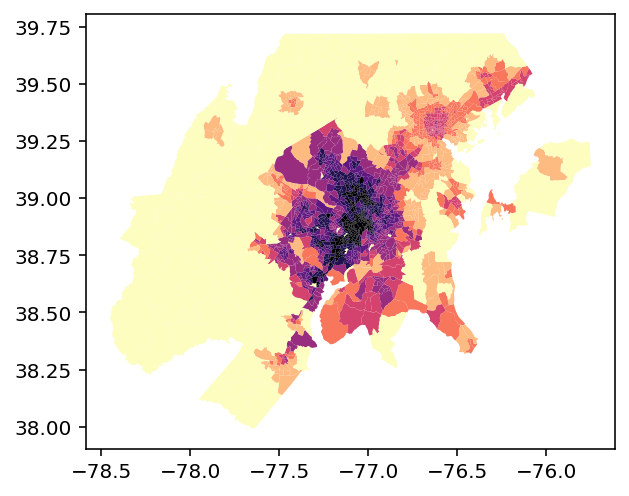

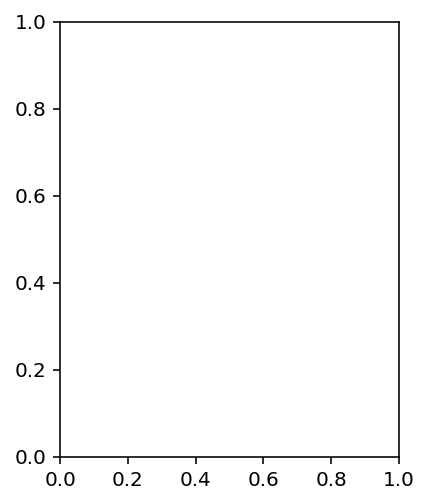

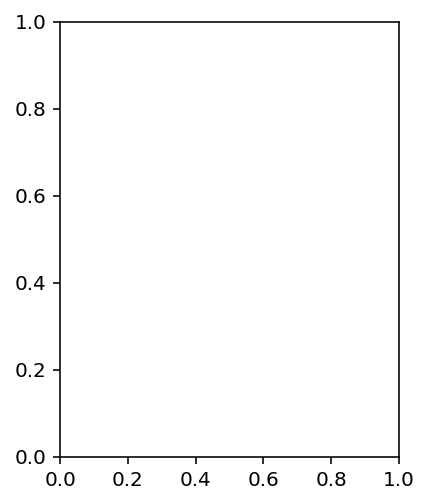

In [33]:
for i in cols:
    try:
        mega.merge(ac_test.access_df, left_on='geoid', right_index=True).plot(i, scheme='quantiles', k=8, cmap='magma_r')
    except:
        pass